给模型参数增加随机性

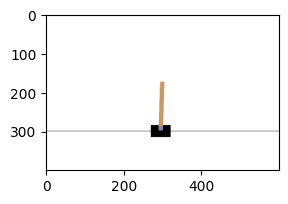

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch


class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
        )

        #输出层参数的均值和标准差
        self.weight_mean = torch.nn.Parameter(torch.randn(64, 2))
        self.weight_std = torch.nn.Parameter(torch.randn(64, 2))

        self.bias_mean = torch.nn.Parameter(torch.randn(2))
        self.bias_std = torch.nn.Parameter(torch.randn(2))
        
    def forward(self, state):
        state = self.fc(state)

        #正态分布投影,获取输出层的参数
        weight = self.weight_mean + torch.randn(64, 2) * self.weight_std
        bias = self.bias_mean + torch.randn(2) * self.bias_std

        #运行模式下不需要随机性
        if not self.training:
            weight = self.weight_mean
            bias = self.bias_mean

        #计算输出
        return state.matmul(weight) + bias


model = Model()
model_delay = Model()

#复制参数
model_delay.load_state_dict(model.state_dict())

model(torch.randn(5, 4)).shape

torch.Size([5, 2])

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        #因为模型本身有随机性,所以这里不需要再随机动作
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

-981.0

In [4]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

/tmp/ipykernel_7154/2282743005.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(202,
 (array([-0.01686703, -0.03263399, -0.02972687, -0.00819585], dtype=float32),
  1,
  1.0,
  array([-0.0175197 ,  0.1629014 , -0.02989078, -0.31010774], dtype=float32),
  False))

In [5]:
#训练
def train():
    model.train()
    model_delay.eval()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()

    #共更新N轮数据
    for epoch in range(1000):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #计算value
            value = model(state).gather(dim=1, index=action)

            #计算target
            with torch.no_grad():
                target = model_delay(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            target = target * 0.99 * (1 - over) + reward

            loss = loss_fn(value, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #复制参数
        if (epoch + 1) % 5 == 0:
            model_delay.load_state_dict(model.state_dict())

        if epoch % 100 == 0:
            model.eval()
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            model.train()
            print(epoch, len(pool), test_result)

            weight = model.weight_mean + 1 * model.weight_std
            bias = model.bias_mean + 1 * model.bias_std
            print('weight=',
                  weight.mean().item(),
                  weight.std().item(), 'bias=', bias.tolist())


train()

0 410 -991.5
weight= -0.05162937939167023 1.5363906621932983 bias= [-0.14915892481803894, 0.19301483035087585]
100 20000 149.75
weight= -0.34773126244544983 1.8414790630340576 bias= [-0.3386839032173157, -0.2702609896659851]
200 20000 200.0
weight= -0.39857396483421326 1.902843713760376 bias= [-0.3145585358142853, -0.17365393042564392]
300 20000 200.0
weight= -0.37846851348876953 1.895090937614441 bias= [-0.394956111907959, -0.053517378866672516]
400 20000 200.0
weight= -0.36975133419036865 1.8895775079727173 bias= [-0.39090868830680847, -0.025117414072155952]
500 20000 200.0
weight= -0.3579482436180115 1.8912266492843628 bias= [-0.39548859000205994, -0.0065963189117610455]
600 20000 200.0
weight= -0.3552493155002594 1.892190933227539 bias= [-0.38327670097351074, 0.0018533050315454602]
700 20000 200.0
weight= -0.34987977147102356 1.8944052457809448 bias= [-0.3704076111316681, 1.5890225768089294e-05]
800 20000 200.0
weight= -0.3472265303134918 1.9024701118469238 bias= [-0.37121301889419

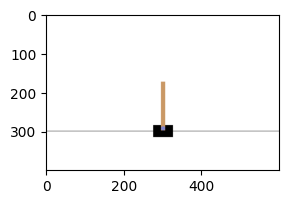

200.0

In [6]:
play(True)[-1]